# 残差网络（ResNet）

残差块

In [1]:
import sys
sys.path.append('..')

In [2]:
import mindspore
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
from d2l import mindspore as d2l

class Residual(nn.Cell):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides, pad_mode='pad')
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1, pad_mode='pad')
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()
        
    def construct(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)

输入和输出形状一致

In [3]:
blk = Residual(3,3)
X = mindspore.Tensor(np.random.rand(4, 3, 6, 6), mindspore.float32)
Y = blk(X)
Y.shape

(4, 3, 6, 6)

增加输出通道数的同时，减半输出的高和宽

In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

(4, 6, 3, 3)

ResNet模型

In [5]:
b1 = nn.SequentialCell(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, pad_mode='pad'),
                       nn.BatchNorm2d(64), nn.ReLU(),
                       d2l.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.SequentialCell(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.SequentialCell(*resnet_block(64, 128, 2))
b4 = nn.SequentialCell(*resnet_block(128, 256, 2))
b5 = nn.SequentialCell(*resnet_block(256, 512, 2))

net = nn.SequentialCell(b1, b2, b3, b4, b5,
                        d2l.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(), nn.Dense(512, 10))

观察一下ResNet中不同模块的输入形状是如何变化的

In [6]:
X = mindspore.Tensor(np.random.rand(1, 1, 224, 224), mindspore.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

SequentialCell output shape:	 (1, 64, 56, 56)
SequentialCell output shape:	 (1, 64, 56, 56)
SequentialCell output shape:	 (1, 128, 28, 28)
SequentialCell output shape:	 (1, 256, 14, 14)
SequentialCell output shape:	 (1, 512, 7, 7)
AdaptiveAvgPool2d output shape:	 (1, 512, 1, 1)
Flatten output shape:	 (1, 512)
Dense output shape:	 (1, 10)


训练模型

loss 0.046, train acc 0.998, test acc 0.913
4380.1 examples/sec


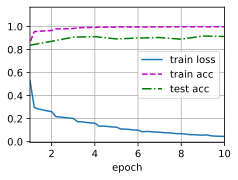

In [8]:
lr, num_epochs, batch_size = 0.05, 10, 256
mnist_train, mnist_test = d2l.load_data_fashion_mnist('../data', batch_size, resize=96)
d2l.train_ch6(net, mnist_train, mnist_test, num_epochs, lr)